## Partie 2 : Séries temporelles

In [1]:
# statistics
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import *
# Charts
%matplotlib inline  
import matplotlib.pyplot as plt
# Utility
import pandas as pd
import numpy as np
from math import *
from dateutil.parser import parse

> ### 21.	Ouvrir le fichier volat.raw; attention aux valeurs manquantes.

In [2]:
"""
http://qed.econ.queensu.ca/jae/1996-v11.5/hamilton-lin/readme.hl.txt
http://fmwww.bc.edu/ec-p/data/wooldridge/volat.des

James D. Hamilton and Gang Lin, "Stock Market Volatility and the 
Business Cycle", Journal of Applied Econometrics, Vol. 11, No. 5, 1996,
pp. 573-593. 

  1. date                     Date (month) 1947.01 to 1993.06
  2. sp500                    S&P 500 index
  3. divyld                   Stock dividend yield, annualized rate
  4. i3                       3 mo. T-bill annualized rate
  5. ip                       index of industrial production
  6. pcsp                     pct chg, sp500, ann rate
  7. rsp500                   return on sp500: pcsp + divyld
  8. pcip                     pct chg, IP, ann. rate
  9. ci3                      i3 - i3[t-1]
 10. ci3_1                    ci3[t-1]
 11. ci3_2                    ci3[t-2]
 12. pcip_1                   pcip[t-1]
 13. pcip_2                   pcip[t-2]
 14. pcip_3                   pcip[t-3]
 15. pcsp_1                   pcip[t-1]
 16. pcsp_2                   pcip[t-2]
 17. pcsp_3                   pcip[t-3]
"""

# read dataset file
df = pd.read_csv('VOLAT.raw', header=None, sep='\s+')
df1 = df.ix[0::3]
df1.columns = ['date', 'sp500', 'divyld', 'i3', 'ip', 'pcsp', 'rsp500']
df1.reset_index(drop=True,inplace=True)
df2 = df.ix[1::3]
df2.columns = ['pcip', 'ci3', 'ci3_1', 'ci3_2', 'pcip_1', 'pcip_2', 'pcip_3']
df2.reset_index(drop=True,inplace=True)
df3 = df.ix[2::3]
df3.drop([3,4,5,6],inplace=True,axis=1)
df3.columns = ['pcsp_1', 'pcsp_2', 'pcsp_3']
df3.reset_index(drop=True,inplace=True)

# merge row lines
df = df1.join(df2).join(df3)

print 'Before removed empty rows : ', str(df.shape)
# remove rows with empty values
df = df.replace('.', np.nan)
df = df.dropna(how='any')
# convert to float
print 'After removed empty rows  : ', str(df.shape)
df = df.astype(float)

Before removed empty rows :  (558, 17)
After removed empty rows  :  (554, 17)


/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


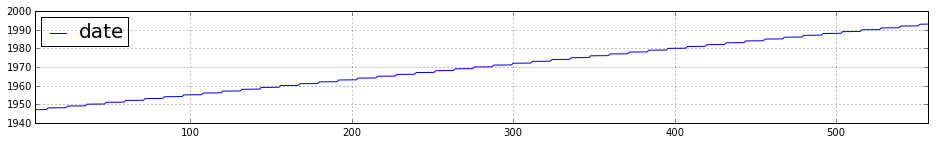

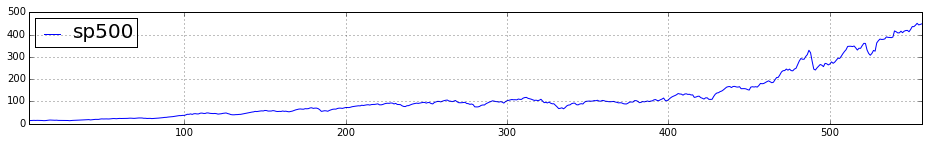

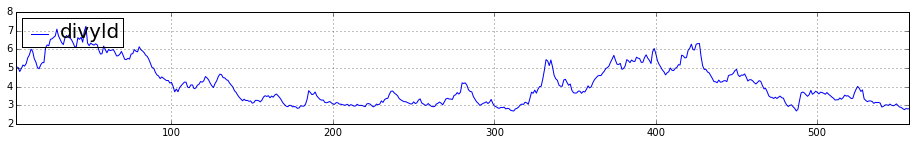

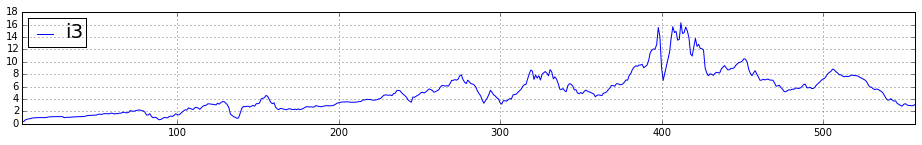

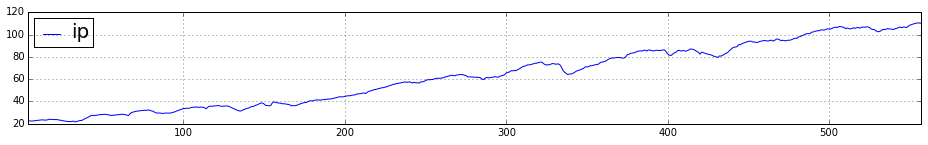

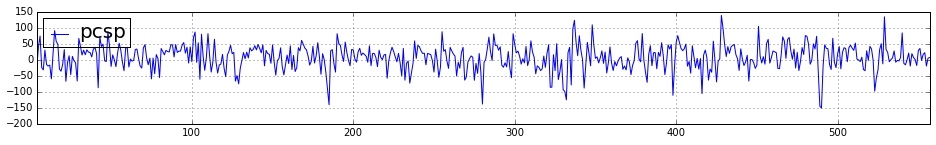

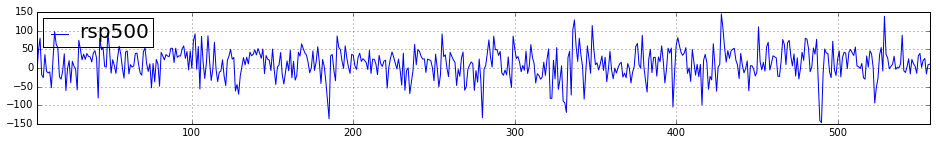

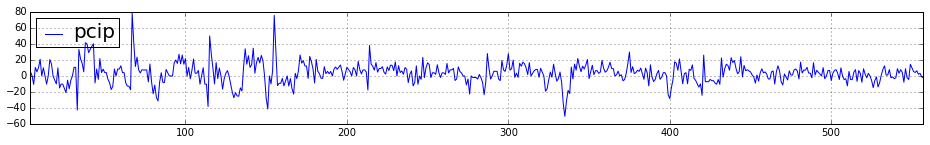

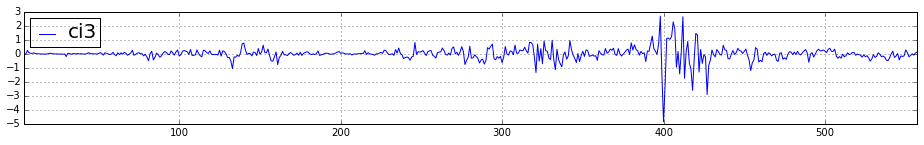

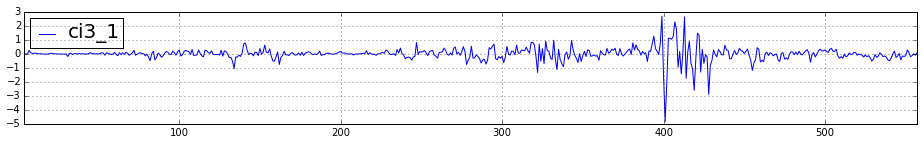

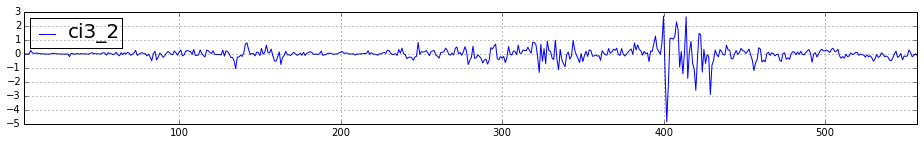

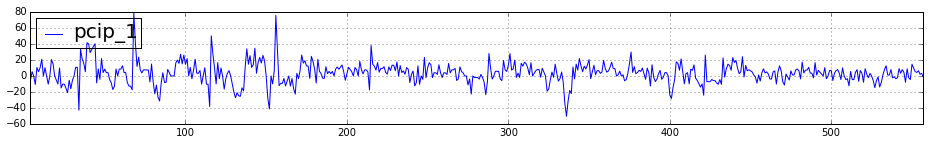

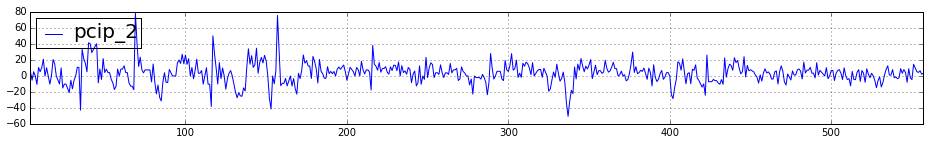

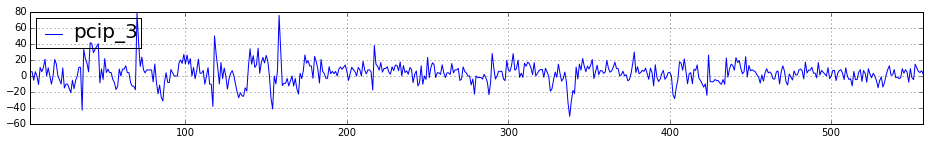

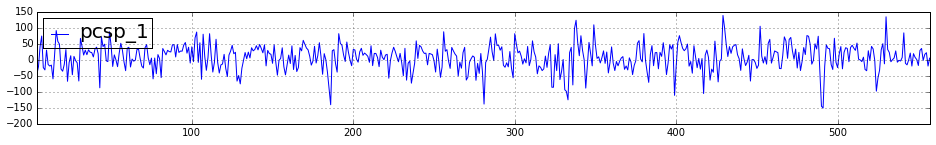

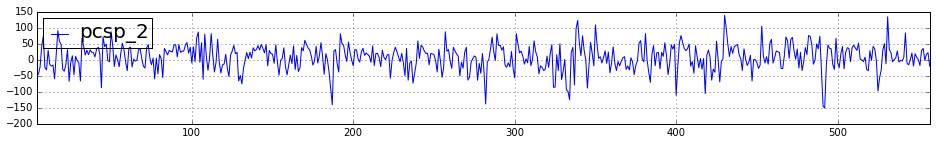

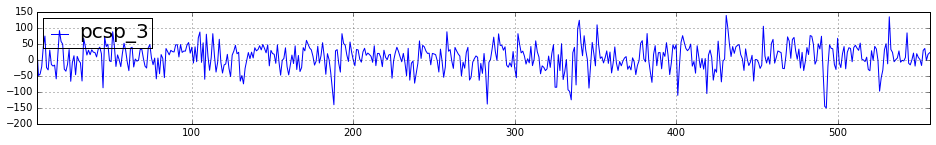

In [3]:
def plot_time_series(df, figsize=(16,2)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    df.plot(ax=ax)
    legend = ax.legend(loc = 'upper left');
    legend.prop.set_size(20);

for df_ts in [pd.Series(df[ts]) for ts in df]:
    plot_time_series(df_ts)

> ### 22.	Pourquoi doit-on stationnariser les séries ?

**On doit stationnariser les séries pour s’assurer de pouvoir les modéliser à l’aide de la méthode des MCO.
En effet, pour une série non-stationnaire, l’hypothèse d’indépendance des observations n’est plus valable. Le théorème centrale limite ne s’applique plus et l’estimateur des MCO n’est plus sans biais.
<br>
D'autre part, la distribution des paramètres de la regression ne suit plus une loi de Student.**

> ### 23.	Faire le test de racine unitaire de log(sp500) H0: p = 1 et le test de Dickey Fuller.

**On teste la racine unitaire de log(sp500) HO: p = 1**

In [25]:
df2 = pd.DataFrame()
df2['log(sp500-1)'] = np.log(df['sp500']).shift()
df2['log(sp500)'] = np.log(df['sp500'])
# drop the first line
df2 = df2.drop(df.index[0])

# apply OLS
y = df2['log(sp500)']
X = df2['log(sp500-1)']
results = smf.OLS(y, X, data=df2).fit()

print results.summary()
#print 'SSR          : ', str(results.ssr)
print '\nTest de Student (H0 : p=1)'
print 'pValue       : ', str(results.t_test("log(sp500-1)=1").pvalue)

                            OLS Regression Results                            
Dep. Variable:             log(sp500)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.918e+06
Date:                Sun, 10 May 2015   Prob (F-statistic):               0.00
Time:                        19:45:29   Log-Likelihood:                 1090.1
No. Observations:                 553   AIC:                            -2178.
Df Residuals:                     552   BIC:                            -2174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
log(sp500-1)     1.0013      0.000   3149.222   

*** On rejette donc, avec une marge d'erreur de 5%, l'hypothèse H0 que p=1.***

<br>
*** Nous pouvons également vérifier cela en appliquant le test de Dickey-Fuller***

In [26]:
# Augmented Dickey-Fuller test
result = sm.tsa.stattools.adfuller(np.log(df['sp500']))
print 'Statistique de Dickey-Fuller      : ', str(result[0])
print 'pValue                            : ', str(result[1])
print 'Valeur critique pour la stat à 5% : ', str(result[4]['5%'])

Statistique de Dickey-Fuller      :  -0.556000914014
pValue                            :  0.880617358127
Valeur critique pour la stat à 5% :  -2.86679973883


**L'hypothèse nulle est donc acceptée avec une pvalue de 0.88, soit 12% d'erreur. On ne peut pas accepter, à 5% d'erreur, la précense d'une racine unitaire.**

> ### 24.	Interpréter l'autocorrélogramme et l'autocorrélogrammes partiels de pcsp et de divyld. Quelle est la différence entre ces deux graphiques ?

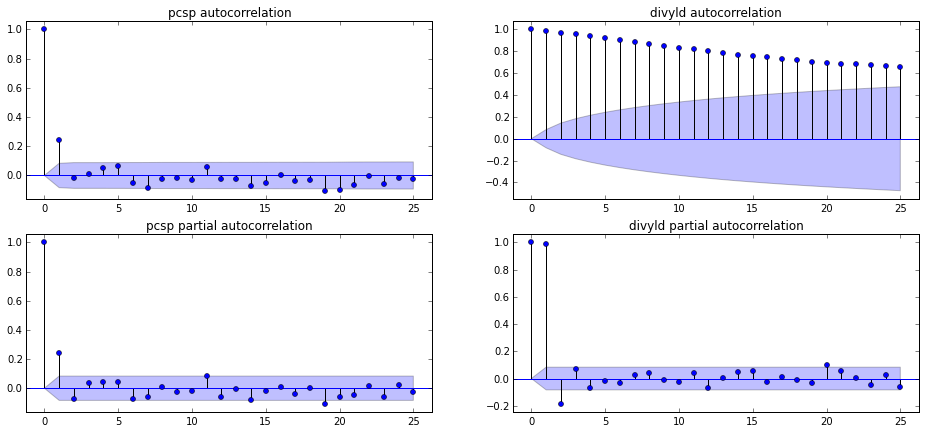

In [215]:
fig_width = 16
fig_height = 7
lags = 25

fig = plt.figure(figsize=(fig_width, fig_height))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(222)
ax4 = fig.add_subplot(220)

# pcsp
plot_acf(df['pcsp'], lags=lags, ax=ax1)
ax1.set_title('pcsp autocorrelation')
plot_pacf(df['pcsp'], lags=lags, ax=ax2)
ax2.set_title('pcsp partial autocorrelation')

# divyld
plot_acf(df['divyld'], lags=lags, ax=ax3)
ax3.set_title('divyld autocorrelation')
plot_pacf(df['divyld'], lags=lags, ax=ax4)
ax4.set_title('divyld partial autocorrelation')

plt.show()

**L'autocorrelogramme et l'autocorrelogramme partiel permettent d'indentifier le type de séries auxquelles on a affaire.
<br>
L'autocorrelogramme est la série formée des fk=corr(yi, yi-k)
<br>
L'autocorrelogramme partiel est construit à partir des coefficients de regression des yi avec les yi-1, yi-2, ..., yi-k. Nous pouvons visuellement connaître l'ordre p gràce aux coefficients importants (1 pour pcsp et 2 pour divyld).
<br>**

** Les autocorrelogrammes permettent ici de dire que l'on a affaire à des processus de type AR.**

> ### 25.	Proposer une modélisation AR(p) de chacune des séries en utilisant les outils et tests vu au cours.


AR(p) for time series :  pcsp_3


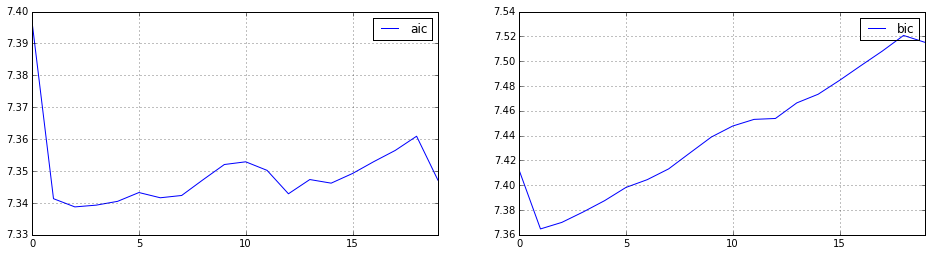

minimum p for aic :  2
minimum p for bic :  1
selected p        :  1  with  bic

AR(p) for time series :  pcsp_3


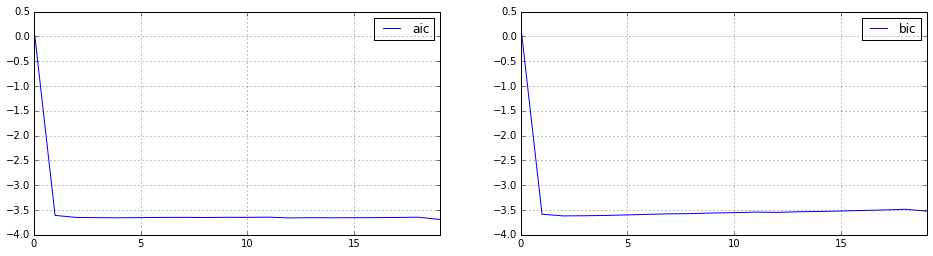

minimum p for aic :  19
minimum p for bic :  2
selected p        :  2  with  bic


In [216]:
# extract date
monthly_timeserie_date = df['date'].apply(lambda x:parse(str(int(ceil(modf(x)[0]*100))) + '/01/' + str(int(modf(x)[1]))))

def get_p_df(df_ts):
    print '\nAR(p) for time series : ', str(ts)
    monthly_timeseries = pd.Series(df_ts.tolist(), index=monthly_timeserie_date, dtype=float)

    #Here we have to use the monthly timeserie as the statsmodels ar_model doesn't understand hourly frequencies
    ar_mod = sm.tsa.ar_model.AR(monthly_timeseries)
    
    #Selection of the optimal order for AR model based on bic
    res_order_aic = []
    res_order_bic = []
    maxlag = 20
    for i in range(0, maxlag):
        ar_res = ar_mod.fit(i)
        res_order_aic.append(ar_res.aic)
        res_order_bic.append(ar_res.bic)

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 4)
    pd.DataFrame(res_order_aic, columns=['aic']).plot(ax=ax1)
    legend = ax1.legend(loc = 'upper right')
    pd.DataFrame(res_order_bic, columns=['bic']).plot(ax=ax2)
    legend = ax2.legend(loc = 'upper right')
    plt.show()
    
    # get the minimum p
    min_p_aic = res_order_aic.index(min(res_order_aic))
    min_p_bic = res_order_bic.index(min(res_order_bic))
    p =  min([min_p_aic, min_p_bic])
    print 'minimum p for aic : ', str(min_p_aic)
    print 'minimum p for bic : ', str(min_p_bic)
    print 'selected p        : ', str(p), ' with ', 'aic' if min_p_aic < min_p_bic else 'bic'
    return ar_mod, p

p_df = dict()
p_df['pcsp'] = get_p_df(df['pcsp'])
p_df['divyld'] = get_p_df(df['divyld'])

**Une fois l'orde p verifié pour pcsp et divyld, nous trouvons les paramètres donnés par notre modèle AR(p) :**

In [217]:
#Fiting models
ar_res = p_df['pcsp'][0].fit(p_df['pcsp'][1])
print '\npcsp : parameters for the model : ', ar_res.params

ar_res = p_df['divyld'][0].fit(p_df['divyld'][1])
print '\ndivyld : parameters for the model : ', ar_res.params


pcsp : parameters for the model :  const    6.217594
L1.y     0.240617
dtype: float64

divyld : parameters for the model :  const    0.050180
L1.y     1.202234
L2.y    -0.215077
dtype: float64


**Nous pouvons constater que la série pcsp peut se modeliser par un modèle AR(1) et la série divyld par un modèle AR(2).**

> ### 26.	Faire une régression de pcsp sur i3 et divyld. Interpréter les résultats. Tester la significativité jointe des variables explicatives

In [218]:
formula = 'pcsp ~ i3 + divyld'
model = smf.ols(formula, data=df)
results = model.fit()

# Results
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                   pcsp   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.016
Date:                Sat, 09 May 2015   Prob (F-statistic):             0.0186
Time:                        12:56:56   Log-Likelihood:                -2828.9
No. Observations:                 554   AIC:                             5664.
Df Residuals:                     551   BIC:                             5677.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     20.9185      7.131      2.933      0.0

**Les résultats de la régression confirment les intuitions suivantes :**
- **Lorsque le cours de la bourse et les taux d'intérêts sont corrélés négativement : une augmentation des taux d'intérêts entraine un report des investissements fait en bourse vers des investissements à moindre risque (d'où un impact négatif sur la bourse). **
- **Inversement, si les dividendes des actions augmentent, l'investissement en bourse est plus intéressant, engendrant ainsi un afflux d'investisseurs.**
- **On constate également que l'effet des dividendes (divyld) est plus fort que celui des taux d'intérêts (i3) sur pcsp.**

**On réalise maintenant l'hypothèse conjointe que i3 = 0 et divyld = 0 par un test de fisher :**

In [219]:
hypotheses = '(i3 = 0), (divyld = 0)'
f_test = results.f_test(hypotheses)
print 'Statistique de test de fisher : ' + str(f_test.fvalue[0][0])
print 'pValue                        : ' + str(f_test.pvalue)

Statistique de test de fisher : 4.01591133138
pValue                        : 0.018556723436


**Nous pouvons rejeter à 5% l'hypothèse d'une non-significativité jointe des variables explicatives suivantes dividendes (divyld) et taux d'intérêts (i3).**

> ### 27.	Tester l'autocorrélation des erreurs.

In [220]:
predictions = results.predict(df[['i3','divyld']])

df_pcsp_err = pd.DataFrame()
df_pcsp_err['pcsp_err'] = df['pcsp'] - predictions
df_pcsp_err['pcsp_err-1'] = df_pcsp_err['pcsp_err'].shift()
# drop the first line
df_pcsp_err = df_pcsp_err.drop(df.index[0])

# apply OLS
results_pcsp_err = smf.ols('pcsp_err ~ pcsp_err-1', data=df_pcsp_err).fit()

# apply student test
hypotheses = '(pcsp_err = 0), (pcsp_err-1 = 0)'
print 'Student test  : ', str(results_pcsp_err.tvalues[0])
print 'pValue        : ', str(results_pcsp_err.pvalues[0])
print 'Durbin-Watson : ', 1.521, #str(sm.stats.stattools.durbin_watson(df_pcsp_err))
print results_pcsp_err.summary()

Student test  :  1.06513581362e+17
pValue        :  0.0
Durbin-Watson :  1.521                             OLS Regression Results                            
Dep. Variable:               pcsp_err   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.135e+34
Date:                Sat, 09 May 2015   Prob (F-statistic):               0.00
Time:                        12:56:56   Log-Likelihood:                 17112.
No. Observations:                 553   AIC:                        -3.422e+04
Df Residuals:                     552   BIC:                        -3.422e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------

**Rappel sur le test non paramétrique de Durbin-Watson :**
- **Sa valeur est comprise entre 0 et 4. **
- **Une valeur proche de zéro indique une autocorrélation positive**
- **les valeurs situées autour de 2 montrent une absence d’autocorrélation**
- **si l’on s’approche de 4, il existe une autocorrélation négative (valeurs tantôt au-dessus et tantôt au-dessous de la tendance).**

**Soit l'hypothèse H0 disant qu'il n'y a pas de correlations des erreurs et H1 : il existe un processus autorégressif d’ordre 1.
<br>
On cherche à savoir si à partir de notre valeur retourné par notre test de Durbin-Watson, on accepte ou non l'hypotèse nulle. 
<br>
Pour ce faire, nous regardons les tables de Durbin-Watson (http://web.stanford.edu/~clint/bench/dw05d.htm) à 5%, n=550 (taille de l'échantillon), et k=2 (nombre de variables explicatives, intercept inclus).
<br>
Cette table nous donne deux limites entre lesquelles il y a un doute (dL et dU).
<br>
Le DW (1.521) se situant entre 0 et 1.85632, on rejette H0. Il se peut qu’il existe une autocorrélation positive d’ordre 1.**

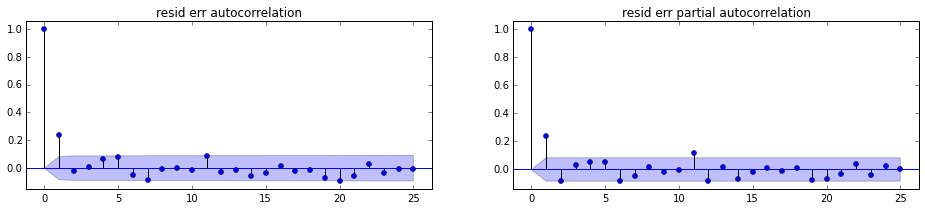

In [221]:
fig_width = 16
fig_height = 3
lags = 25

fig = plt.figure(figsize=(fig_width, fig_height))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(120)

plot_acf(results_pcsp_err.resid, lags=lags, ax=ax1)
ax1.set_title('resid err autocorrelation')

plot_pacf(results_pcsp_err.resid, lags=lags, ax=ax2)
ax2.set_title('resid err partial autocorrelation')

plt.show()

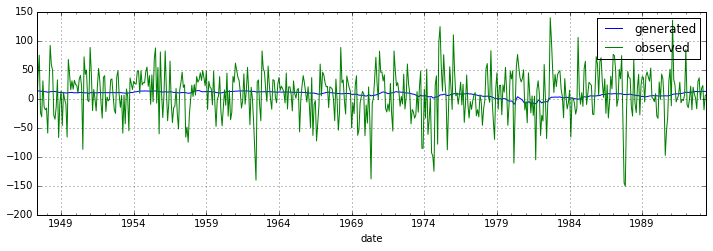

In [222]:
# plot
monthly_timeserie_date = df['date'].apply(lambda x:parse(str(int(ceil(modf(x)[0]*100))) + '/01/' + str(int(modf(x)[1]))))
monthly_pcsp_pred = pd.Series(predictions.tolist(), index=monthly_timeserie_date, dtype=float)
monthly_pcsp = pd.Series(df['pcsp'].tolist(), index=monthly_timeserie_date, dtype=float)

fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(211)
monthly_pcsp_pred.resample('M', how='mean').plot(label='generated', ax=ax1)
monthly_pcsp.resample('M', how='mean').plot(label='observed', ax=ax1)
plt.legend()
plt.show()

**Nous constatons ici un fort écart entre les valeurs réells et les valeurs prédites par notre modèle.**